# 1. Load libraries

In [48]:
#Load libraries
import os

import numpy as np
import torch
import glob
import torch.nn as nn
from torch import optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import time
import copy
from torch.optim import lr_scheduler


import argparse
import datetime
import torch
import json
import numpy as np

from pathlib import Path
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torchvision import datasets, models
from torchvision.models import resnet18, ResNet18_Weights


# 2. Define Transforms

In [32]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])


# 3. Define Dataloader

In [33]:
# Path for training, validation and testing directory

data_dir = 'split_data'
train_path = data_dir + '/train'
val_path = data_dir + '/val'
test_path = data_dir + '/test'

In [34]:

# Load the datasets with ImageFolder :

training_dataset = datasets.ImageFolder(train_path, transform=training_transforms)

validation_dataset = datasets.ImageFolder(val_path, transform=validation_transforms)

testing_dataset = datasets.ImageFolder(test_path, transform=testing_transforms)

# Using the image datasets and the tranforms, define the dataloaders :

train_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=32
)

test_loader = torch.utils.data.DataLoader(
        testing_dataset, batch_size=16
)


In [47]:
# Print the different classes : 
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


['DL', 'FO', 'OT']


In [51]:
# Label mapping : 

import json

with open('angle_to_name.json', 'r') as f:
    angle_to_name = json.load(f)
    
print(len(angle_to_name)) 
print(angle_to_name)

3
{'DL': 'Side angle', 'FO': 'Face-on angle', 'OT': 'other'}


# 4. Build and train the classifier

In [ ]:
model = models.vgg16(pretrained=True)
model

In [69]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 3)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [70]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        #images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [71]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [75]:
# Train the classifier

def train_classifier():

    epochs = 1
    steps = 0
    print_every = 40

    #model.to('cuda')

    for e in range(epochs):
        
        model.train()
    
        running_loss = 0
    
        for images, labels in iter(train_loader):
        
            steps += 1
        
            #images, labels = images.to('cuda'), labels.to('cuda')
        
            optimizer.zero_grad()
        
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                
                model.eval()
                
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, val_loader, criterion)
            
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                        "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                        "Validation Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
                        "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader)))
            
                running_loss = 0
                model.train()
                    
train_classifier() 

Epoch: 1/1..  Training Loss: 0.612..  Validation Loss: 0.407..  Validation Accuracy: 0.912
Epoch: 1/1..  Training Loss: 0.369..  Validation Loss: 0.249..  Validation Accuracy: 0.921
Epoch: 1/1..  Training Loss: 0.289..  Validation Loss: 0.207..  Validation Accuracy: 0.939
Epoch: 1/1..  Training Loss: 0.323..  Validation Loss: 0.233..  Validation Accuracy: 0.922
Epoch: 1/1..  Training Loss: 0.271..  Validation Loss: 0.198..  Validation Accuracy: 0.937
Epoch: 1/1..  Training Loss: 0.281..  Validation Loss: 0.179..  Validation Accuracy: 0.946
Epoch: 1/1..  Training Loss: 0.309..  Validation Loss: 0.215..  Validation Accuracy: 0.938
Epoch: 1/1..  Training Loss: 0.283..  Validation Loss: 0.194..  Validation Accuracy: 0.934
Epoch: 1/1..  Training Loss: 0.266..  Validation Loss: 0.186..  Validation Accuracy: 0.940
Epoch: 1/1..  Training Loss: 0.291..  Validation Loss: 0.218..  Validation Accuracy: 0.932
Epoch: 1/1..  Training Loss: 0.258..  Validation Loss: 0.189..  Validation Accuracy: 0.940

KeyboardInterrupt: 

# 5. Testing your network

In [76]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    #model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            #images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

KeyboardInterrupt: 

# 6. Save the checkpoint

In [77]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)   

In [78]:
# Load the checkpoint 

from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

#model = load_checkpoint('checkpoint.pth')
#print(model)

# 7. Inference for classification

In [79]:
# Image processing :
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

<AxesSubplot:>

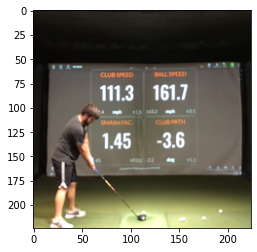

In [81]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('split_data/test/DL/0c105560-0cd8-11ed-a424-2cf05d55567e.jpg')
imshow(image)

In [90]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    #image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    image = torch.from_numpy(image).type(torch.FloatTensor)

    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('split_data/test/DL/0c105560-0cd8-11ed-a424-2cf05d55567e.jpg', model)   
print(probs)
print(classes)

[0.9982153177261353, 0.0017846929840743542, 1.385055981018013e-08]
['DL', 'OT', 'FO']


# 8. Other models

In [36]:
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, stride=1, padding=1):
        nn.Module.__init__(self)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, out_channels=output_dim,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output_dim),
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=output_dim, out_channels=output_dim,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output_dim),
        )
        self.relu = nn.ReLU()
        if self.input_dim != self.output_dim:
            self.residual_layer = nn.Sequential(
                nn.Conv2d(in_channels=input_dim, out_channels=output_dim,
                          kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(output_dim),
            )

    def forward(self, input):
        x = self.layer_1(input)
        x = self.relu(x)
        x = self.layer_2(x)
        if self.input_dim != self.output_dim:
            residual = self.residual_layer(input)
        else:
            residual = input
        x += residual
        output = self.relu(x)
        return output

In [37]:
def create_cascade_block(input_dims, output_dims, block, **block_args):
    num_channels = len(input_dims)
    cascade = []
    for n in range(num_channels):
        cascade.append(
            block(input_dim=input_dims[n], output_dim=output_dims[n], **block_args))
    return nn.Sequential(*cascade)

In [38]:
class ConvNet(nn.Module):
    def __init__(self, input_dim=3, input_size=256, output_dim=7, channel_sizes=[16, 32, 64, 128, 256], kernel_size=3, stride=1):
        super(ConvNet, self).__init__()

        self.input_size = input_size
        self.channel_sizes = channel_sizes
        self.num_channels = len(channel_sizes) - 1

        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=input_dim,
                      out_channels=self.channel_sizes[0], kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) / 2)),
            nn.BatchNorm2d(channel_sizes[0]),
            nn.ReLU(),
        )
        self.convolutions = create_cascade_block(
            input_dims=self.channel_sizes[:-1], output_dims=self.channel_sizes[1:], block=BasicBlock, kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) / 2))
        self.pooling = nn.MaxPool2d(kernel_size=2)

        self.output_layer =  nn.Sequential(
            nn.Linear(in_features=int((self.input_size / (2 ** self.num_channels)) * (self.input_size / (2 ** self.num_channels)) * self.channel_sizes[-1]), out_features=self.channel_sizes[-1]),
            nn.BatchNorm1d(channel_sizes[-1]),
            nn.ReLU(),
            nn.Linear(in_features=self.channel_sizes[-1], out_features=output_dim),
        )
    def forward(self, input):

        x = self.input_layer(input)
        
        for block in self.convolutions:
            x = self.pooling(x)
            x = block(x)
            
        x = x.view(-1, int((self.input_size / (2 ** self.num_channels)) *
                   (self.input_size / (2 ** self.num_channels)) * self.channel_sizes[-1]))
        output = self.output_layer(x)
        return output

In [ ]:
net = ConvNet()
net